In [ ]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR
from torchvision.models import VisionTransformer
from tqdm import tqdm
import time
import os
import shutil

In [ ]:
from tkinter import Tk
from tkinter.filedialog import askdirectory

# Hide the main Tkinter window
Tk().withdraw()
# Print the selected folder
print(f"Please select the folder from the pop up, it will appear after you minimize this window:")
# Ask the user to select the folder with custom text
home_folder = askdirectory(title="Select the Project_submission folder")

# Check if a folder was selected
if not home_folder:
    print("No folder selected. Exiting.")
    exit()

# Print the selected folder or use it in your script
print(f"Selected folder: {home_folder}")


In [ ]:


# def copy_folder(source_folder, destination_folder):
#     try:
#         shutil.copytree(source_folder, destination_folder)
#         print(f'Folder "{source_folder}" copied to "{destination_folder}" successfully.')
#     except Exception as e:
#         print(f'Error copying folder: {e}')

# # Example usage:
# source_folder = '/content/drive/MyDrive/Cattle_DataSet_4_Classes_yolo_dataset'
# destination_folder = 'Cattle_DataSet_4_Classes_yolo_dataset'
# copy_folder(source_folder, destination_folder)


Folder "/content/drive/MyDrive/Cattle_DataSet_4_Classes_yolo_dataset" copied to "Cattle_DataSet_4_Classes_yolo_dataset" successfully.


In [ ]:

train_dir = os.path.join(home_folder,"Dataset/Cattle Dentition Datasets after Segmentation/4 Age Groups/train")
test_dir = os.path.join(home_folder,"Dataset/Cattle Dentition Datasets after Segmentation/4 Age Groups/test")
val_dir = os.path.join(home_folder,"Dataset/Cattle Dentition Datasets after Segmentation/4 Age Groups/val")

train_dir = os.path.join(home_folder, train_dir)
test_dir =  os.path.join(home_folder, test_dir)
val_dir = os.path.join(home_folder, val_dir)


In [ ]:
import torch
import timm

In [ ]:

batch_size = 32
train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = datasets.ImageFolder(val_dir, transform=val_transform)
val_loader = DataLoader(val_dataset, batch_size=batch_size)


num_classes = len(train_dataset.classes)

In [ ]:


def train_vision_transformer(train_loader, val_loader, num_classes , batch_size=32, num_epochs=10, learning_rate=1e-4):

    # Example usage:
    model_name = 'vit_base_patch16_224_in21k'
    pretrained = True   # Set to False if you don't want to use pre-trained weights
    model = load_pretrained_vision_transformer(model_name, num_classes, pretrained)
    #model = VisionTransformer.from_pretrained('vit_base_patch16_224_in21k')

    model.head = nn.Linear(model.head.in_features, num_classes)

    criterion = nn.CrossEntropyLoss()
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    start_time = time.time()
    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        correct = 0
        total = 0
        with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch') as progress_bar:
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_train_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                progress_bar.update(1)
        epoch_train_loss = running_train_loss / len(train_dataset)
        train_losses.append(epoch_train_loss)
        epoch_train_accuracy = correct / total
        train_accuracies.append(epoch_train_accuracy)

        model.eval()
        running_val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        epoch_val_loss = running_val_loss / len(val_dataset)
        val_losses.append(epoch_val_loss)
        epoch_val_accuracy = correct / total
        val_accuracies.append(epoch_val_accuracy)

        print(f'Training Loss: {epoch_train_loss:.4f}, '
              f'Training Accuracy: {epoch_train_accuracy:.4f}, '
              f'Validation Loss: {epoch_val_loss:.4f}, '
              f'Validation Accuracy: {epoch_val_accuracy:.4f}')

        scheduler.step()

    end_time = time.time()
    total_training_time = end_time - start_time
    print(f'Total training time: {total_training_time:.2f} seconds')

    print('Training finished.')
    return model, train_losses, train_accuracies, val_losses, val_accuracies

In [ ]:
model, train_losses, train_accuracies, val_losses, val_accuracies= train_vision_transformer(train_loader , val_loader , num_classes , 32 , 15 , 1e-5 )

In [ ]:
# Save results to a text file
with open(os.path.join(home_folder,"MODEL TRAINING/1/Model_Results/Accuracy_Curves/vit_epoch_results.txt"), "w") as f:
    f.write("Epoch\tTrain_Loss\tTrain_Accuracy\tVal_Loss\tVal_Accuracy\n")
    for epoch in range(len(train_accuracies)):
        f.write(f"{epoch+1}\t{train_losses[epoch]:.4f}\t{train_accuracies[epoch]:.4f}\t{val_losses[epoch]:.4f}\t{val_accuracies[epoch]:.4f}\n")

print("Training results saved to vit_epoch_results.txt")

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import numpy as np
import seaborn as sns

def test_model(model, test_loader, batch_size=32):


    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_accuracy = correct / total
    print(f'Testing Accuracy: {test_accuracy:.4f}')
    return test_accuracy

import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

def save_accuracy_curves(train_losses, val_losses, train_accuracies, val_accuracies, save_path):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy', color='blue')
    plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.ylim(0, 1)  # Set the y-axis limit from 0 to 1

    # Save the image of accuracy curves
    plt.savefig(save_path)
    print(f'Accuracy curves saved to: {save_path}')
    plt.close()


# Example usage:
# Assuming `train_losses`, `val_losses`, `train_accuracies`, and `val_accuracies` are lists of losses and accuracies during training
#save_accuracy_curves(train_losses, val_losses, train_accuracies, val_accuracies, os.path.join(home_folder,"MODEL TRAINING/1/Model_Results/Accuracy_Curves"))


In [ ]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, test_loader, class_names=None, save_path=None):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
    if class_names:
        tick_marks = range(len(class_names))
        plt.xticks(tick_marks, class_names, rotation=45)
        plt.yticks(tick_marks, class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    if save_path:
        plt.savefig(save_path)
    plt.show()

# Example usage:
# Assuming model and test_loader are provided
# model: trained model
# test_loader: test data loader
# class_names: list of class names (optional)
# save_path: path to save the figure (optional)



def calculate_metrics(model, test_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}')


In [ ]:
# Assuming `trained_model` is the model returned from `train_vision_transformer`
test_accuracy = test_model(model, test_loader)
test_accuracy

In [ ]:
# Assuming `train_losses`, `val_losses`, and `val_accuracies` are lists of losses and accuracies during training
save_accuracy_curves(train_losses, val_losses, train_accuracies, val_accuracies, os.path.join(home_folder,"MODEL TRAINING/1/Model_Results/Accuracy_Curves"))



In [ ]:
class_names = ["grp_41", "grp_42", "grp_43", "grp_44"]

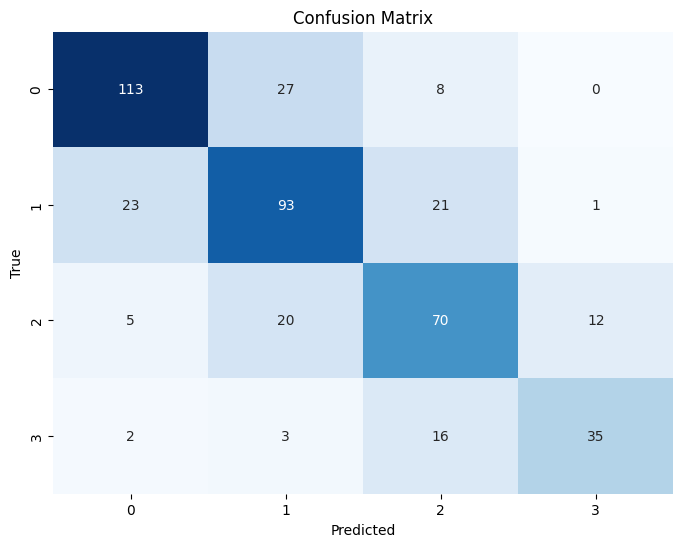

Precision: 0.6964, Recall: 0.6927, F1-score: 0.6937


In [ ]:
# Assuming `test_loader` is the DataLoader for the test dataset
plot_confusion_matrix(model, test_loader , class_names )
calculate_metrics(model, test_loader)


In [ ]:
import os

def save_model(model, model_name, save_path):



    # Save the model to the specified path
    torch.save(model.state_dict(), os.path.join(save_path , model_name))
    print(f'Model saved to: {save_path}')

# Example usage:
# Assuming `trained_model` is the model returned from `train_vision_transformer`
# and `save_path` is the path where you want to save the model file
# For example, 'models/vision_transformer_model.pth'
save_model(model, 'vision_transformer_model_4_classes.pth', os.path.join(home_folder,"MODEL TRAINING/1/Model_Results/Models"))


Model saved to: /content/drive/MyDrive/ML Model Results/1/Vision_Transform


In [ ]:
import shutil

# def copy_folder(source_folder, destination_folder):
#     try:
#         shutil.copytree(source_folder, destination_folder)
#         print(f'Folder "{source_folder}" copied to "{destination_folder}" successfully.')
#     except Exception as e:
#         print(f'Error copying folder: {e}')

# # Example usage:
# source_folder = '/content/drive/MyDrive/Cattle_DataSet_7_Classes_yolo_dataset'
# destination_folder = 'Cattle_DataSet_7_Classes_yolo_dataset'
# copy_folder(source_folder, destination_folder)

Folder "/content/drive/MyDrive/Cattle_DataSet_7_Classes_yolo_dataset" copied to "Cattle_DataSet_7_Classes_yolo_dataset" successfully.


In [ ]:
train_dir = os.path.join(home_folder,"Dataset/Cattle Dentition Datasets after Segmentation/7 Age Groups/train")
test_dir = os.path.join(home_folder,"Dataset/Cattle Dentition Datasets after Segmentation/7 Age Groups/test")
val_dir = os.path.join(home_folder,"Dataset/Cattle Dentition Datasets after Segmentation/7 Age Groups/val")

train_dir = os.path.join(home_folder, train_dir)
test_dir =  os.path.join(home_folder, test_dir)
val_dir = os.path.join(home_folder, val_dir)


In [ ]:

batch_size = 32
train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = datasets.ImageFolder(val_dir, transform=val_transform)
val_loader = DataLoader(val_dataset, batch_size=batch_size)


num_classes = len(train_dataset.classes)

In [ ]:
model1, train_losses, train_accuracies, val_losses, val_accuracies= train_vision_transformer(train_loader , val_loader , num_classes , 32 , 15 , 1e-5 )

In [ ]:
# Save results to a text file
with open(os.path.join(home_folder,"MODEL TRAINING/2/Model_Results/Accuracy_Curves/vit_epoch_results.txt"), "w") as f:
    f.write("Epoch\tTrain_Loss\tTrain_Accuracy\tVal_Loss\tVal_Accuracy\n")
    for epoch in range(len(train_accuracies)):
        f.write(f"{epoch+1}\t{train_losses[epoch]:.4f}\t{train_accuracies[epoch]:.4f}\t{val_losses[epoch]:.4f}\t{val_accuracies[epoch]:.4f}\n")

print("Training results saved to vit_epoch_results.txt")

In [ ]:
# Assuming `trained_model` is the model returned from `train_vision_transformer`
test_accuracy = test_model(model1, test_loader)
test_accuracy

Testing Accuracy: 0.5535


0.5535307517084282

In [ ]:
# Assuming `train_losses`, `val_losses`, and `val_accuracies` are lists of losses and accuracies during training
save_accuracy_curves(train_losses, val_losses, train_accuracies, val_accuracies, os.path.join(home_folder,"MODEL TRAINING/2/Model_Results/Accuracy_Curves"))


Accuracy curves saved to: /content/drive/MyDrive/ML Model Results/2/Vision_Transform/accuracy_curves.png


In [ ]:
class_names = ["grp_71", "grp_72", "grp_73", "grp_74","grp_75", "grp_76", "grp_77"]

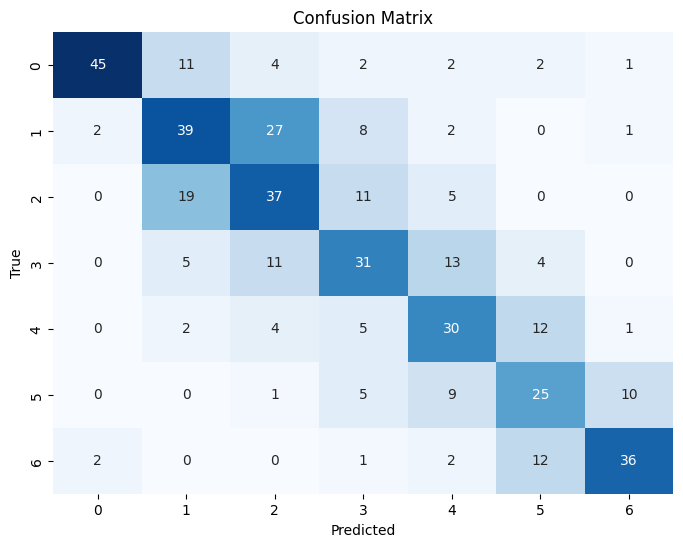

Precision: 0.5755, Recall: 0.5535, F1-score: 0.5605


In [ ]:
# Assuming `test_loader` is the DataLoader for the test dataset
plot_confusion_matrix(model1, test_loader , class_names )
calculate_metrics(model1, test_loader)


In [ ]:
save_model(model1, 'vision_transformer_model_7_classes.pth',os.path.join(home_folder,"MODEL TRAINING/2/Model_Results/Models") )


Model saved to: /content/drive/MyDrive/ML Model Results/2/Vision_Transform


In [ ]:
import shutil

# def copy_folder(source_folder, destination_folder):
#     try:
#         shutil.copytree(source_folder, destination_folder)
#         print(f'Folder "{source_folder}" copied to "{destination_folder}" successfully.')
#     except Exception as e:
#         print(f'Error copying folder: {e}')

# # Example usage:
# source_folder = '/content/drive/MyDrive/Cattle_DataSet_15_Classes_yolo_dataset'
# destination_folder = 'Cattle_DataSet_15_Classes_yolo_dataset'
# copy_folder(source_folder, destination_folder)

Folder "/content/drive/MyDrive/Cattle_DataSet_15_Classes_yolo_dataset" copied to "Cattle_DataSet_15_Classes_yolo_dataset" successfully.


In [ ]:

train_dir = os.path.join(home_folder,"Dataset/Cattle Dentition Datasets after Segmentation/15 Age Groups/train")
test_dir = os.path.join(home_folder,"Dataset/Cattle Dentition Datasets after Segmentation/15 Age Groups/test")
val_dir = os.path.join(home_folder,"Dataset/Cattle Dentition Datasets after Segmentation/15 Age Groups/val")

train_dir = os.path.join(home_folder, train_dir)
test_dir =  os.path.join(home_folder, test_dir)
val_dir = os.path.join(home_folder, val_dir)

In [ ]:

batch_size = 32
train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = datasets.ImageFolder(val_dir, transform=val_transform)
val_loader = DataLoader(val_dataset, batch_size=batch_size)


num_classes = len(train_dataset.classes)

In [ ]:
model2, train_losses, train_accuracies, val_losses, val_accuracies= train_vision_transformer(train_loader , val_loader , num_classes , 32 , 15 , 1e-5 )

/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name vit_base_patch16_224_in21k to current vit_base_patch16_224.augreg_in21k.
  model = create_fn(
Epoch 1/15: 100%|██████████| 63/63 [01:29<00:00,  1.42s/batch]


Training Loss: 2.6803, Training Accuracy: 0.1409, Validation Loss: 2.2860, Validation Accuracy: 0.2160


Epoch 2/15: 100%|██████████| 63/63 [01:27<00:00,  1.39s/batch]


Training Loss: 2.0548, Training Accuracy: 0.2714, Validation Loss: 2.0094, Validation Accuracy: 0.3075


Epoch 3/15: 100%|██████████| 63/63 [01:29<00:00,  1.42s/batch]


Training Loss: 1.6530, Training Accuracy: 0.4218, Validation Loss: 1.8599, Validation Accuracy: 0.3310


Epoch 4/15: 100%|██████████| 63/63 [01:28<00:00,  1.40s/batch]


Training Loss: 1.1964, Training Accuracy: 0.6011, Validation Loss: 1.7397, Validation Accuracy: 0.3451


Epoch 5/15: 100%|██████████| 63/63 [01:28<00:00,  1.40s/batch]


Training Loss: 1.0697, Training Accuracy: 0.6549, Validation Loss: 1.7379, Validation Accuracy: 0.3545


Epoch 6/15: 100%|██████████| 63/63 [01:28<00:00,  1.40s/batch]


Training Loss: 0.9895, Training Accuracy: 0.6833, Validation Loss: 1.7671, Validation Accuracy: 0.3568


Epoch 7/15: 100%|██████████| 63/63 [01:27<00:00,  1.40s/batch]


Training Loss: 0.9252, Training Accuracy: 0.7276, Validation Loss: 1.7389, Validation Accuracy: 0.3545


Epoch 8/15: 100%|██████████| 63/63 [01:28<00:00,  1.41s/batch]


Training Loss: 0.9004, Training Accuracy: 0.7375, Validation Loss: 1.7383, Validation Accuracy: 0.3638


Epoch 9/15: 100%|██████████| 63/63 [01:28<00:00,  1.41s/batch]


Training Loss: 0.8976, Training Accuracy: 0.7291, Validation Loss: 1.7392, Validation Accuracy: 0.3521


Epoch 10/15: 100%|██████████| 63/63 [01:29<00:00,  1.42s/batch]


Training Loss: 0.8958, Training Accuracy: 0.7351, Validation Loss: 1.7391, Validation Accuracy: 0.3521


Epoch 11/15: 100%|██████████| 63/63 [01:30<00:00,  1.43s/batch]


Training Loss: 0.8852, Training Accuracy: 0.7430, Validation Loss: 1.7391, Validation Accuracy: 0.3545


Epoch 12/15: 100%|██████████| 63/63 [01:28<00:00,  1.40s/batch]


Training Loss: 0.8948, Training Accuracy: 0.7311, Validation Loss: 1.7391, Validation Accuracy: 0.3545


Epoch 13/15: 100%|██████████| 63/63 [01:27<00:00,  1.40s/batch]


Training Loss: 0.8918, Training Accuracy: 0.7435, Validation Loss: 1.7391, Validation Accuracy: 0.3545


Epoch 14/15: 100%|██████████| 63/63 [01:27<00:00,  1.39s/batch]


Training Loss: 0.8856, Training Accuracy: 0.7351, Validation Loss: 1.7391, Validation Accuracy: 0.3545


Epoch 15/15: 100%|██████████| 63/63 [01:27<00:00,  1.40s/batch]


Training Loss: 0.8891, Training Accuracy: 0.7301, Validation Loss: 1.7391, Validation Accuracy: 0.3545
Total training time: 1558.41 seconds
Training finished.


In [ ]:
# Save results to a text file
with open(os.path.join(home_folder,"MODEL TRAINING/3/Model_Results/Accuracy_Curves/vit_epoch_results.txt"), "w") as f:
    f.write("Epoch\tTrain_Loss\tTrain_Accuracy\tVal_Loss\tVal_Accuracy\n")
    for epoch in range(len(train_accuracies)):
        f.write(f"{epoch+1}\t{train_losses[epoch]:.4f}\t{train_accuracies[epoch]:.4f}\t{val_losses[epoch]:.4f}\t{val_accuracies[epoch]:.4f}\n")

print("Training results saved to vit_epoch_results.txt")

In [ ]:
# Assuming `trained_model` is the model returned from `train_vision_transformer`
test_accuracy = test_model(model2, test_loader)
test_accuracy

Testing Accuracy: 0.3541


0.35412026726057905

In [ ]:
# Assuming `train_losses`, `val_losses`, and `val_accuracies` are lists of losses and accuracies during training
save_accuracy_curves(train_losses, val_losses, train_accuracies, val_accuracies, os.path.join(home_folder,"MODEL TRAINING/3/Model_Results/Accuracy_Curves"))


Accuracy curves saved to: /content/drive/MyDrive/ML Model Results/3/Vision_Transform/accuracy_curves.png


In [ ]:
class_names = ['up to 10 year', 'up to 11 year', 'up to 12 year', 'up to 13 year', 'up to 14 year', 'up to 15 year', 'up to 16 year', 'up to 2 year', 'up to 3 year', 'up to 4 year', 'up to 5 year', 'up to 6 year', 'up to 7 year', 'up to 8 year', 'up to 9 year']

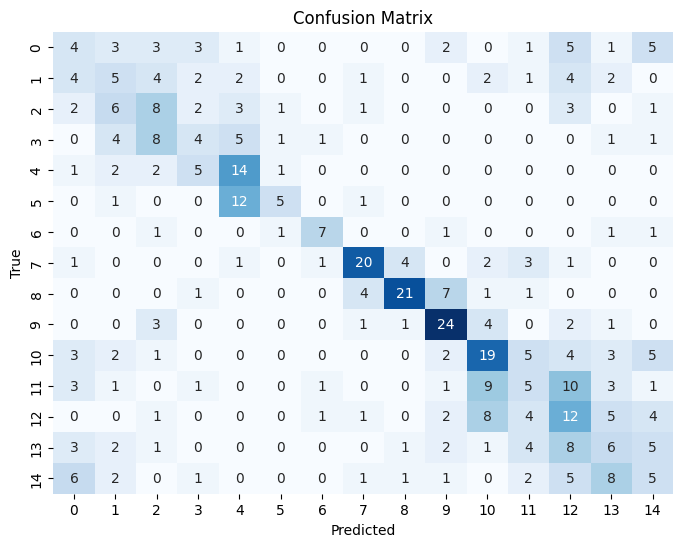

Precision: 0.3623, Recall: 0.3541, F1-score: 0.3524


In [ ]:
# Assuming `test_loader` is the DataLoader for the test dataset
plot_confusion_matrix(model2, test_loader, class_names )
calculate_metrics(model2, test_loader)


In [ ]:
save_model(model2, 'vision_transformer_model_15_classes.pth',os.path.join(home_folder,"MODEL TRAINING/3/Model_Results/Models"))


Model saved to: /content/drive/MyDrive/ML Model Results/3/Vision_Transform
